# Tarea 4: Psicrometría
### Pablo Correa e Ian Gross

## Librerías

In [2]:
import CoolProp.CoolProp as cp
import fluids as fld
import numpy as np
import scipy.constants as cte
import scipy.optimize as opt
import matplotlib.pyplot as plt

from fluids.units import *

from PIL import Image

In [4]:
g = cte.g*u.m/u.s**2
Patm = (1*u.atm).to(u.Pa)

# Pregunta 1
Un flujo de aire (corriente 1) a 60°F , 1 atm y 30 % de humedad relativa se mezcla adiabáticamente
con un flujo de aire (corriente 2) a 90°F , 1 atm y 80 % de humedad relativa. Una sola corriente (corriente
3) sale de la cámara de mezcla a una temperatura T3 y 1 atm. Suponga un estado estacionario e ignore
los efectos de energía cinética y potencial. Sea r la relación de los caudales másicos de aire seco  ̇$\dot{m}_{a,1}/\dot{m}_{a,2}$:

(a) (3 pts) Determine T3, en ◦C, para r = 2.

(b) (3 pts) Ilustre el proceso de mezcla en un diagrama psicrométrico.

(c) (3 pts) Construya un gráfico de T3 versus r, variando r de 0 a 10.

## Parte A

In [46]:
T_1 = (60*u.fahrenheit).to(u.kelvin)
T_2 = (90*u.fahrenheit).to(u.kelvin)
HR_1 = 0.3
HR_2 = 0.8

P = Patm
r = 2

Utilizando la humedad relativa, se obtiene la humedad absoluta y la entalpía específica para las corrientes de entrada (1 y 2)

In [43]:
w_1 = cp.HAPropsSI('W', 'T', T_1.magnitude, 'R', HR_1, 'P', P.magnitude)
h_1 = cp.HAPropsSI('H', 'T', T_1.magnitude, 'R', HR_1, 'P', P.magnitude)*u.joule/u.kilogram

w_2 = cp.HAPropsSI('W', 'T', T_2.magnitude, 'R', HR_2, 'P', P.magnitude)
h_2 = cp.HAPropsSI('H', 'T', T_2.magnitude, 'R', HR_2, 'P', P.magnitude)*u.joule/u.kilogram

Las ecuaciones de balance de masa, masa humeda y energía para el caso de mezcla adiabática son

$$\dot{m}_1 + \dot{m}_2 = \dot{m}_3$$

$$\dot{m}_1 \omega_1 + \dot{m}_2 \omega_2 = \dot{m}_3 \omega_3$$

$$\dot{m}_1 h_1 + \dot{m}_2 h_2 = \dot{m}_3 h_3$$

Dada la definición de $r$ y el balance de masas se tiene que

$$\dot{m}_1 = r \dot{m}_2$$

$$\dot{m}_3 = (1 + r)\dot{m}_2$$

Con estos resultados se tiene que la humedad absoluta y entalpía específica de salida serían

$$\omega_3 = \frac{r \omega_1 + \omega_2}{r + 1}$$

$$h_3 = \frac{r h_1 + h_2}{r + 1}$$

In [44]:
def corriente_3(corriente_1, corriente_2, r):
    value = (r*corriente_1 + corriente_2)/(r+1)
    return value

w_3 = corriente_3(w_1, w_2, r)
h_3 = corriente_3(h_1, h_2, r)

print(w_1, w_2, w_3)

0.0032858262222819723 0.024717042648684476 0.010429565031082806


Luego, utilizando la humedad específica y la entalpía específica en la corriente 3, se puede utilizar CoolProp para obtener la temperatura correspondiente en la corriente 3.

In [8]:
T_3 = cp.HAPropsSI('T', 'W', w_3, 'H', h_3.magnitude, 'P', P.magnitude)

T_3 = (T_3*u.kelvin).to(u.celsius)
print(f"Temperatura de Salida: {T_3}")

Temperatura de Salida: 21.252768065219698 degree_Celsius


## Parte B

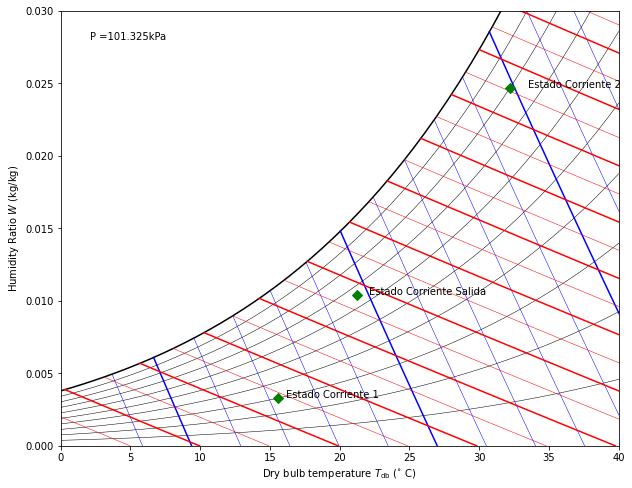

In [54]:
fig, ax = plt.subplots(1,1,figsize=(10, 8))
Tdbvec = np.linspace(0, 40)+273.15

# Lines of constant relative humidity
for RH in np.arange(0.1, 1, 0.1):
    W = cp.HAPropsSI("W","R",RH,"P",P.magnitude,"T",Tdbvec)
    plt.plot(Tdbvec-273.15, W, color='k', lw = 0.5)

# Saturation curve
W = cp.HAPropsSI("W","R",1,"P",P.magnitude,"T",Tdbvec)
plt.plot(Tdbvec-273.15, W, color='k', lw=1.5)

# Lines of constant Vda
for Vda in np.arange(0.79, 1.041, 0.01):
    R = np.linspace(0,1)
    W = cp.HAPropsSI("W","R",R,"P",P.magnitude,"Vda",Vda)
    Tdb = cp.HAPropsSI("Tdb","R",R,"P",P.magnitude,"Vda",Vda)
    plt.plot(Tdb-273.15, W, color='b', lw=1.5 if abs(Vda % 0.05) < 0.001 else 0.5)

# Lines of constant Enthalpy
for h in np.arange(0, 120, 5):
    R = np.linspace(0.0, 1)
    Tdb = cp.HAPropsSI("Tdb","R",R,"P",P.magnitude,"H",h*1000)
    W = cp.HAPropsSI("W","R",R,"P",P.magnitude,"Tdb",Tdb)
    plt.plot(Tdb-273.15, W, color='r', lw=1.5 if abs(h % 10) < 0.001 else 0.5)

ax.annotate('P =' + f'{P.magnitude/1000}' + 'kPa', xy=(2, 0.0275), xytext=(2.1,0.028))

# Puntos con los estado termodinámicos
e_h = 1.04 # Espaciamiento horizontal
# Estado Corriente 1
plt.scatter(T_1.to(u.celsius).magnitude, w_1, c='g',s=50,zorder=5,marker='D') 
plt.annotate('Estado Corriente 1', ((T_1.to(u.celsius).magnitude)*e_h, w_1))
# Estado Corriente 1
plt.scatter(T_2.to(u.celsius).magnitude, w_2, c='g',s=50,zorder=5,marker='D') 
plt.annotate('Estado Corriente 2', ((T_2.to(u.celsius).magnitude)*e_h, w_2))
# Estado Corriente 3
plt.scatter(T_3.to(u.celsius).magnitude, w_3, c='g',s=50,zorder=5,marker='D') 
plt.annotate('Estado Corriente Salida', ((T_3.to(u.celsius).magnitude)*e_h, w_3))

plt.xlabel(r'Dry bulb temperature $T_{\rm db}$ ($^{\circ}$ C)')
plt.ylabel(r'Humidity Ratio $W$ (kg/kg)')
plt.ylim(0, 0.03)
plt.xlim(0, 40)
plt.show()

## Parte C

Aplicando la solución para la parte (a), se resuelve y se grafica la temperatura en la corriente 3 en relación a la razón $r$.

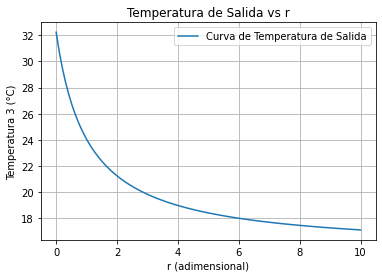

In [8]:
def Temp_3(w_1, w_2, h_1, h_2, r):
    w_3 = corriente_3(w_1, w_2, r)
    h_3 = corriente_3(h_1, h_2, r)
    T_3 = cp.HAPropsSI('T', 'W', w_3, 'H', h_3.magnitude, 'P', P.magnitude)*u.kelvin

    return T_3.to(u.celsius)

r_range = np.linspace(0,10,100)

T_3_range = [Temp_3(w_1, w_2, h_1, h_2, r_range[i]).magnitude for i in range(100)]

# plot curva de sistema
plt.plot(r_range, T_3_range, label='Curva de Temperatura de Salida')

# aspectos visuales
plt.xlabel('r (adimensional)')
plt.ylabel('Temperatura 3 (°C)')
plt.title('Temperatura de Salida vs r')
plt.legend()
plt.grid(True)
plt.show()

# Pregunta 2
Se debe suministrar, en estado estacionario, aire húmedo a una sala de clases a una tasa de flujo
volumétrico y temperatura T especificadas. El aire es retirado de la sala en una corriente diferente que
se encuentra a una temperatura de 27°C y 50 % de humedad relativa. Se agrega humedad al aire en
la habitación desde los ocupantes a una tasa de 4,5 kg/h. La humedad puede considerarse como vapor
saturado a 33°C. La transferencia de calor al espacio ocupado desde todas las fuentes se estima en
34,000 kJ/h. La presión permanece uniforme en 1 atm.

(a) (3 pts) Para una tasa de flujo volumétrico de aire suministrado de 40 m3/min, determine la
temperatura del aire suministrado T , en °C, y la humedad relativa.

(b) (3 pts) Ilustre el proceso de mezcla en un diagrama psicrométrico.

(c) (3 pts) Construya un gráfico de la temperatura del aire suministrado, en °C , y la humedad
relativa,ambas vs la tasa de flujo volumétrico de aire suministrado, variando esta última de 35 a
90 m3/min.

## Parte A

In [23]:
T_out = (27*u.celsius).to(u.kelvin)
HR_out = 0.5

m_v = (4.5*u.kg/u.hour).to(u.kg/u.s)
T_v = (33*u.celsius).to(u.kelvin)

q_in = (34000*u.kJ/u.h).to(u.W)

P = Patm
flow_rates_in = (40*u.m**3/u.min).to(u.m**3/u.s)

Usando los datos entregados, se calcula con CoolProp la humedad específica, entalpía y flujo másico que circula por la sala.

Para el flujo másico se considera que

$$\dot{m}_a = \frac{\dot{V}}{v}$$

In [24]:
w_out = cp.HAPropsSI('W', 'T', T_out.magnitude, 'R', HR_out, 'P', P.magnitude)
h_out = cp.HAPropsSI('H', 'T', T_out.magnitude, 'R', HR_out, 'P', P.magnitude)*u.joule/u.kilogram

V = cp.HAPropsSI('V', 'T', T_out.magnitude, 'R', HR_out, 'P', P.magnitude)*u.m**3/u.kilogram
m_a = flow_rates_in / V

Para resolver el problema considerandolo como un problema de humidificación se resuelve el balance de masa de humedad y de entalpía del sistema, considerando que la masa del sistema es constante

$$\dot{m}_{air} \omega_{in} + \dot{m}_{vapor} = \dot{m}_{air} \omega_{out}$$

$$\dot{m}_{air} h_{in} = \dot{m}_{air} h_{out} + \dot{Q}$$

Se considera que la entalpía asociada a la humedad es despreciable. Resolviendo para la humedad y entalpía específica de salida se tiene que

$$\omega_{in} = \omega_{out} - \frac{\dot{m}_{vapor}}{\dot{m}_{air}}$$

$$h_{in} = h_{out} + \frac{\dot{Q}}{\dot{m}_{air}}$$

Resolviendolo numerícamente, resulta en

In [28]:
w_in = w_out - m_v/m_a
h_in = h_out + q_in/m_a

T_in = (cp.HAPropsSI('T', 'H', h_in.magnitude, 'W', w_in.magnitude, 'P', P.magnitude)*u.kelvin).to(u.celsius)
R_in = cp.HAPropsSI('R', 'H', h_in.magnitude, 'W', w_in.magnitude, 'P', P.magnitude)

print(f"Temperatura de entrada: {T_in}")
print(f"Humedad relativa de entrada: {R_in}")
print(f"Humedad específica de entrada: {w_in}")

Temperatura de entrada: 42.99915393140907 degree_Celsius
Humedad relativa de entrada: 0.17669286995449632
Humedad específica de entrada: 0.009573138268671053 dimensionless


## Parte B

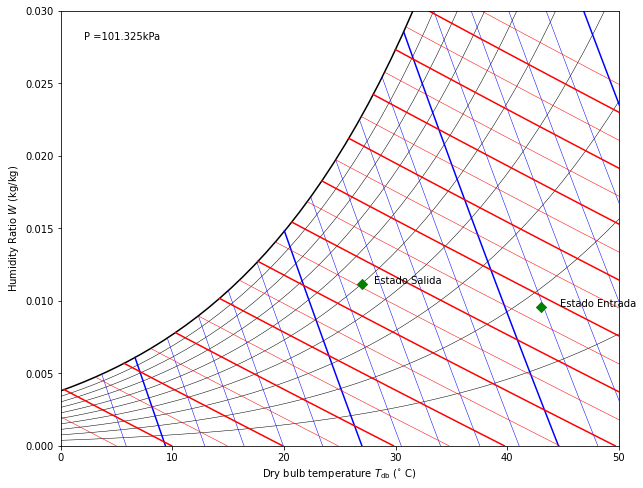

In [32]:
fig, ax = plt.subplots(1,1,figsize=(10, 8))
Tdbvec = np.linspace(0, 50)+273.15

# Lines of constant relative humidity
for RH in np.arange(0.1, 1, 0.1):
    W = cp.HAPropsSI("W","R",RH,"P",P.magnitude,"T",Tdbvec)
    plt.plot(Tdbvec-273.15, W, color='k', lw = 0.5)

# Saturation curve
W = cp.HAPropsSI("W","R",1,"P",P.magnitude,"T",Tdbvec)
plt.plot(Tdbvec-273.15, W, color='k', lw=1.5)

# Lines of constant Vda
for Vda in np.arange(0.79, 1.041, 0.01):
    R = np.linspace(0,1)
    W = cp.HAPropsSI("W","R",R,"P",P.magnitude,"Vda",Vda)
    Tdb = cp.HAPropsSI("Tdb","R",R,"P",P.magnitude,"Vda",Vda)
    plt.plot(Tdb-273.15, W, color='b', lw=1.5 if abs(Vda % 0.05) < 0.001 else 0.5)

# Lines of constant Enthalpy
for h in np.arange(0, 120, 5):
    R = np.linspace(0.0, 1)
    Tdb = cp.HAPropsSI("Tdb","R",R,"P",P.magnitude,"H",h*1000)
    W = cp.HAPropsSI("W","R",R,"P",P.magnitude,"Tdb",Tdb)
    plt.plot(Tdb-273.15, W, color='r', lw=1.5 if abs(h % 10) < 0.001 else 0.5)

ax.annotate('P =' + f'{P.magnitude/1000}' + 'kPa', xy=(2, 0.0275), xytext=(2.1,0.028))

# Puntos con los estado termodinámicos
e_h = 1.04 # Espaciamiento horizontal
# Estado Entrada
plt.scatter(T_in.magnitude, w_in, c='g',s=50,zorder=5,marker='D') 
plt.annotate('Estado Entrada', ((T_in.magnitude)*e_h, w_in))
# Estado Salida
plt.scatter(T_out.to(u.celsius).magnitude, w_out, c='g',s=50,zorder=5,marker='D') 
plt.annotate('Estado Salida', ((T_out.to(u.celsius).magnitude)*e_h, w_out))

plt.xlabel(r'Dry bulb temperature $T_{\rm db}$ ($^{\circ}$ C)')
plt.ylabel(r'Humidity Ratio $W$ (kg/kg)')
plt.ylim(0, 0.030)
plt.xlim(0, 50)
plt.show()

## Parte C

Basado en el desarrollo de la parte (A), se definen las siguientes funciones

In [12]:
def mass_air(T, HR, P, flow_rates):
    V = cp.HAPropsSI('V', 'T', T.magnitude, 'R', HR, 'P', P.magnitude)*u.m**3/u.kilogram
    m_a = flow_rates / V
    return m_a

def calculate_w_in(m_a, m_v, w_out):
    w_in = w_out - m_v/m_a
    return w_in

def calculate_h_in(m_a, q_in, h_out):
    h_in = h_out + q_in/m_a
    return h_in

def Temp_in(w, h, P):
    T_in = cp.HAPropsSI('T', 'W', w, 'H', h.magnitude, 'P', P.magnitude)*u.kelvin
    return T_in.to(u.celsius)

def R_in(w, h, P):
    R_in = cp.HAPropsSI('R', 'W', w, 'H', h.magnitude, 'P', P.magnitude)
    return R_in

Definiendo el rango de flujos de interés, se resuelve numéricamente los arreglos correspondientes y se grafican

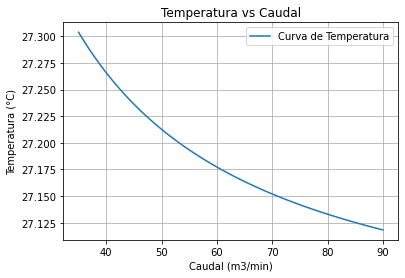

In [13]:
flow_rates = np.linspace(35,90,100)*u.m**3/u.s

m_a_range = mass_air(T_out, HR_out, P, flow_rates)
w_in_range = np.zeros(100)
h_in_range = np.zeros(100)*u.joule/u.kilogram
for i in range(100):
    w_in_range[i] = calculate_w_in(m_a_range[i], m_v, w_out)
    h_in_range[i] = calculate_h_in(m_a_range[i], q_in, h_out)

T_range = [Temp_in(w_in_range[i], h_in_range[i], P).magnitude for i in range(100)]

# plot curva de sistema
plt.plot(flow_rates.magnitude, T_range, label='Curva de Temperatura')

# aspectos visuales
plt.xlabel('Caudal (m3/min)')
plt.ylabel('Temperatura (°C)')
plt.title('Temperatura vs Caudal')
plt.legend()
plt.grid(True)
plt.show()

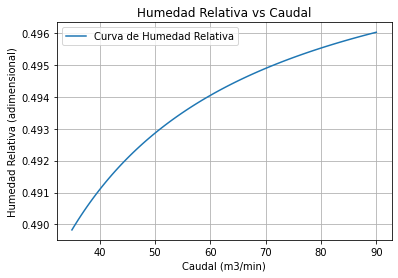

In [14]:
R_range = [cp.HAPropsSI('R', 'H', h_in_range[i].magnitude, 'W', w_in_range[i], 'P', P.magnitude) for i in range(100)]

# plot curva de sistema
plt.plot(flow_rates.magnitude, R_range, label='Curva de Humedad Relativa')

# aspectos visuales
plt.xlabel('Caudal (m3/min)')
plt.ylabel('Humedad Relativa (adimensional)')
plt.title('Humedad Relativa vs Caudal')
plt.legend()
plt.grid(True)
plt.show()

# Pregunta 3
Considere los datos de la instalación de APR en Hualañé, incluyendo la distribución de diámetros y
la bomba seleccionada en las entregas anteriores.

a) (3pts) Verique el pñunto de operación y si se cumple la jnormativa, en el escenario que 3 nuevas
vivuiendas sean construídas en el sector más alto de Hualañé.

b) (3pts) Sugiera una solución a la situación anteior, para asegurar el suministro bajo las normas de
servicios sanitarios.

# Bibliografía

[1] https://www.stainless-structurals.com/blog/comparing-the-thermal-conductivity-of-stainless-steel-to-other-metals/